In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import sys

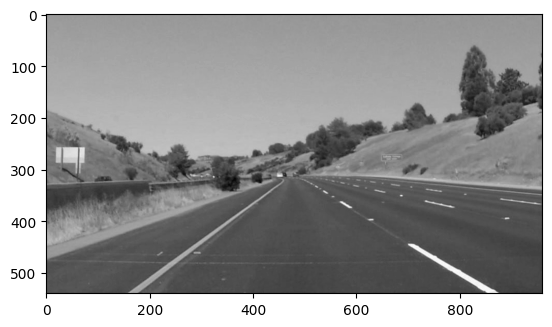

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

image = mpimg.imread('lane.jpeg')
grayscaled = grayscale(image)
plt.imshow(grayscaled, cmap='gray')

In [3]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
  
kernelSize = 5
gaussianBlur = gaussian_blur(grayscaled, kernelSize)

In [4]:
def canny(img, low_threshold, high_threshold):

    return cv2.Canny(img, low_threshold, high_threshold)

minThreshold = 100
maxThreshold = 200
edgeDetectedImage = canny(gaussianBlur, minThreshold, maxThreshold)

In [8]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

lowerLeftPoint = [130, 540]
upperLeftPoint = [410, 350]
upperRightPoint = [570, 350]
lowerRightPoint = [915, 540]

pts = np.array([[lowerLeftPoint, upperLeftPoint, upperRightPoint, 
lowerRightPoint]], dtype=np.int32)
masked_image = region_of_interest(edgeDetectedImage, pts)

In [9]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
              minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

rho = 1
theta = np.pi/180
threshold = 30
min_line_len = 20 
max_line_gap = 20

houged = hough_lines(masked_image, rho, theta, 
                  threshold, min_line_len, max_line_gap)

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    imshape = img.shape

    ymin_global = img.shape[0]
    ymax_global = img.shape[0]

    all_left_grad = []
    all_left_y = []
    all_left_x = []

    all_right_grad = []
    all_right_y = []
    all_right_x = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            ymin_global = min(min(y1, y2), ymin_global)
            
            if (gradient > 0):
                all_left_grad += [gradient]
                all_left_y += [y1, y2]
                all_left_x += [x1, x2]
            else:
                all_right_grad += [gradient]
                all_right_y += [y1, y2]
                all_right_x += [x1, x2]
    
    left_mean_grad = np.mean(all_left_grad)
    left_y_mean = np.mean(all_left_y)
    left_x_mean = np.mean(all_left_x)
    left_intercept = left_y_mean - (left_mean_grad * left_x_mean)
    
    right_mean_grad = np.mean(all_right_grad)
    right_y_mean = np.mean(all_right_y)
    right_x_mean = np.mean(all_right_x)
    right_intercept = right_y_mean - (right_mean_grad * right_x_mean)

    if ((len(all_left_grad) > 0) and (len(all_right_grad) > 0)):
        upper_left_x = int((ymin_global - left_intercept) / left_mean_grad)
        lower_left_x = int((ymax_global - left_intercept) / left_mean_grad)
        upper_right_x = int((ymin_global - right_intercept) / right_mean_grad)
        lower_right_x = int((ymax_global - right_intercept) / right_mean_grad)

        cv2.line(img, (upper_left_x, ymin_global), 
                      (lower_left_x, ymax_global), color, thickness)
        cv2.line(img, (upper_right_x, ymin_global), 
                      (lower_right_x, ymax_global), color, thickness)

In [11]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)

colored_image = weighted_img(houged, image)

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    grayscaled = grayscale(image)

    kernelSize = 5
    gaussianBlur = gaussian_blur(grayscaled, kernelSize)

    minThreshold = 100
    maxThreshold = 200
    edgeDetectedImage = canny(gaussianBlur, minThreshold, maxThreshold)

    lowerLeftPoint = [130, 540]
    upperLeftPoint = [410, 350]
    upperRightPoint = [570, 350]
    lowerRightPoint = [915, 540]

    pts = np.array([[lowerLeftPoint, upperLeftPoint, upperRightPoint, 
                    lowerRightPoint]], dtype=np.int32)
    masked_image = region_of_interest(edgeDetectedImage, pts)

    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 20 
    max_line_gap = 20

    houged = hough_lines(masked_image, rho, theta, threshold, min_line_len, 
                         max_line_gap)

    colored_image = weighted_img(houged, image)
    return colored_image

output = 'output9999.mp4'
clip1 = VideoFileClip("test3.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

Moviepy - Building video output9999.mp4.
Moviepy - Writing video output9999.mp4



Moviepy - Done !
Moviepy - video ready output9999.mp4
CPU times: total: 8.75 s
Wall time: 16.5 s
